<h1>Primo Progetto<h1>

In [3]:
# Importo le librerie richieste
import pandas as pd
from serpapi import GoogleScholarSearch
import json
import networkx as nx
import matplotlib.pyplot as plt
import os
from pyvis.network import Network

In [3]:
GoogleScholarSearch.SERP_API_KEY = "0abb32444148ee2f5264785a1516d02307eb96aac922da2b728ebafd3683d690"

#### 1 | Utilizzo della libreria Python SerpAPI per scaricare, per ciascuno dei 7 autori elencati nel file nodes.csv

In [ ]:
# Importo il file nodes.csv
df = pd.read_csv('data/nodes.csv')
display(df)

In [ ]:

updated_df = pd.DataFrame(columns=['author_id', 'cited_by', 'interests'])

# Itero su ogni autore del dataframe
for index, row in df.iterrows():
    author_name = row['name']
    author_affliation = row['affiliations']
        
    params = {
        "engine" : "google_scholar_profiles",
        "hl": "en",
        "mauthors":f'{author_name},{author_affliation}'
    }
    search = GoogleScholarSearch(params)
    results = search.get_dict()['profiles']
    
    for profile in results:
        author_id = profile['author_id']
        cited_by = profile['cited_by']
        
        interests = []
        
        for interest in profile.get('interests', ):
            title = interest.get('title', '')
            interests.append(title)
    
    interests_str = ', '.join(interests)
    
    # Aggiungo una nuova riga al dataframe updated_df
    new_row = {'author_id': author_id, 'cited_by': cited_by, 'interests': interests_str}
    updated_df = pd.concat([updated_df, pd.DataFrame([new_row])], ignore_index=True)

new_df = pd.merge(df, updated_df, left_index=True, right_index=True)
display(new_df)



In [ ]:
# Sovrascrivo il file nodes.csv con le nuove informazioni trovate
new_df.to_csv('data/nodes.csv', index=False)

#### 2a

In [ ]:
# Carica il file CSV aggiornato con gli ID degli autori
df = pd.read_csv('data/nodes.csv')

# Crea un DataFrame vuoto per i coautori
coauthors_df = pd.DataFrame(columns=['name', 'affiliations', 'author_id', 'cited_by', 'interests'])

# Itera su ogni autore
for index, row in df.iterrows():
    author_id = row['author_id']
    
    # Recupera il profilo dell'autore utilizzando l'ID
    author_params = {
        "engine": "google_scholar_author",
        "author_id": author_id,
        "hl": "en"
    }
    author_search = GoogleScholarSearch(author_params)
    author_profile = author_search.get_dict()

    # Elenca i coautori
    coauthors = author_profile.get('co_authors', [])

    # Per ogni coautore, esegui una ricerca separata includendo le affiliazioni
    for coauthor in coauthors:
        coauthor_name = coauthor['name']
        coauthor_affiliation = coauthor.get('affiliations', '')  # Se disponibile

        # Ricerca il profilo del coautore
        coauthor_params = {
            "engine": "google_scholar_profiles",
            "hl": "en",
            "mauthors": f"{coauthor_name} {coauthor_affiliation}"
        }
        coauthor_search = GoogleScholarSearch(coauthor_params)
        coauthor_results = coauthor_search.get_dict()['profiles'][0]  # Prende il primo profilo come corretto

        # Crea una riga con le informazioni del coautore
        new_row = pd.DataFrame([{
            'name': coauthor_results['name'],
            'affiliations': coauthor_results.get('affiliations', ''),
            'author_id': coauthor_results.get('author_id', ''),
            'cited_by': coauthor_results.get('cited_by', ''),
            'interests': ', '.join([interest['title'] for interest in coauthor_results.get('interests', [])])
        }])

        # Aggiunge la nuova riga al DataFrame
        coauthors_df = pd.concat([coauthors_df, new_row], ignore_index=True)

# Rimuove i doppioni e ordina per nome
coauthors_df.drop_duplicates(inplace=True)
coauthors_df.sort_values(by='name', inplace=True)

# Salva il DataFrame in un file CSV
coauthors_df.to_csv('data/coauthors.csv', index=False)

#### 2b

In [ ]:
# Carica i DataFrame
df1 = pd.read_csv('data/nodes.csv')  # DataFrame degli autori originali
df2 = pd.read_csv('data/coauthors.csv')  # DataFrame dei coautori

# Concatena i DataFrame degli autori originali e dei coautori
combined_df = pd.concat([df1, df2], ignore_index=True)

# Ordina il DataFrame combinato per nome
combined_df.sort_values(by='name', inplace=True)

# Rimuovi eventuali duplicati basati sull'ID dell'autore (da provare anche senza "author_id")
combined_df.drop_duplicates(inplace=True) # combined_df.drop_duplicates(subset='author_id', inplace=True)

# Salva il DataFrame combinato in un file CSV
combined_df.to_csv('data/combined_authors.csv', index=False)

#### 2C

In [ ]:
# Carica il file nodes.csv aggiornato con name, affiliations,author_id, cited_by e interests dei 7 autori originali
df = pd.read_csv('data/nodes.csv')

# Inizializza un DataFrame vuoto per le relazioni di coautorialità
edges_df = pd.DataFrame(columns=['author1', 'author2'])

# Itera su ogni autore originale
for index, row in df.iterrows():
    author_name = row['name']
    author_id = row['author_id']

    # Recupera il profilo dell'autore utilizzando l'ID
    author_params = {
        "engine": "google_scholar_author",
        "author_id": author_id,
        "hl": "en"
    }
    author_search = GoogleScholarSearch(author_params)
    author_profile = author_search.get_dict()

    # Elenca i coautori
    coauthors = author_profile.get('co_authors', [])

    # Per ogni coautore
    for coauthor in coauthors:
        coauthor_name = coauthor['name']
        # Crea un nuovo DataFrame con la relazione di coautorialità
        new_row = pd.DataFrame([{'author1': author_name, 'author2': coauthor_name}])
        # Aggiungi la relazione di coautorialità al DataFrame edges_df utilizzando pd.concat
        edges_df = pd.concat([edges_df, new_row], ignore_index=True)

# Salva il DataFrame in un file CSV
edges_df.to_csv('data/edges.csv', index=False)

#### Aggiustamenti prima di procedere ai punti successivi

In [ ]:
# Percorsi dei file
path_nodes = 'data/nodes.csv'
path_coauthors = 'data/coauthors.csv'
path_combined_authors = 'data/combined_authors.csv'
new_path_nodes = 'data/nodes.csv'

# Elimina nodes.csv e coauthors.csv se esistono
if os.path.exists(path_nodes):
    os.remove(path_nodes)

if os.path.exists(path_coauthors):
    os.remove(path_coauthors)

# Rinomina combined_authors.csv in nodes.csv
if os.path.exists(path_combined_authors):
    os.rename(path_combined_authors, new_path_nodes)

In [ ]:
# Carica il DataFrame edges
edges_df = pd.read_csv('data/edges.csv')

# Crea una colonna temporanea con set di autori
edges_df['author_pair'] = edges_df.apply(lambda row: frozenset([row['author1'], row['author2']]), axis=1)

# Rimuovi i duplicati basati sulla colonna dei set di autori
edges_df = edges_df.drop_duplicates(subset='author_pair')

# Elimina la colonna temporanea
edges_df = edges_df.drop('author_pair', axis=1)

# Salva il DataFrame aggiornato
edges_df.to_csv('data/edges_cleaned.csv', index=False)

In [ ]:
# Percorsi dei file
path_edges = 'data/edges.csv'
path_edges_cleaned = 'data/edges_cleaned.csv'

# Elimina edges.csv se esiste
if os.path.exists(path_edges):
    os.remove(path_edges)

# Rinomina edges_cleaned.csv in edges.csv
if os.path.exists(path_edges_cleaned):
    os.rename(path_edges_cleaned, path_edges)

#### 3a

In [15]:
nodes = pd.read_csv('data/nodes.csv')
edges = pd.read_csv('data/edges.csv')

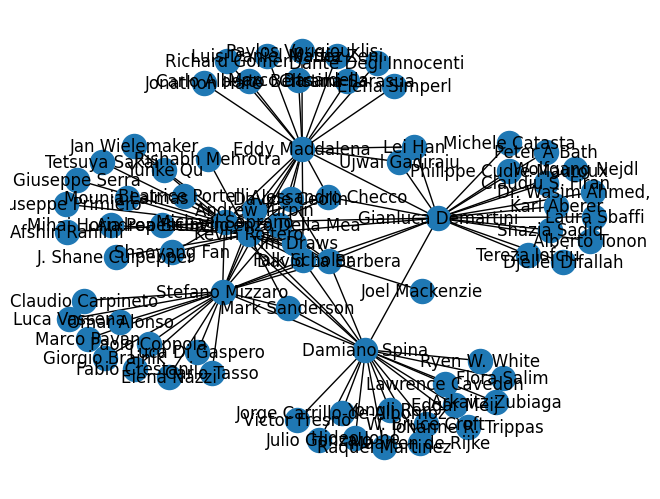

In [16]:
grafo = nx.Graph()

for nome in nodes['name']: 
    grafo.add_node(nome)

for index, row in edges.iterrows():
    grafo.add_edge(row['author1'], row['author2'])
     
nx.draw(grafo, with_labels=True)
plt.show()

nx.write_gml(grafo,"graphs/coauthorship_graph.gml")

#### 3b

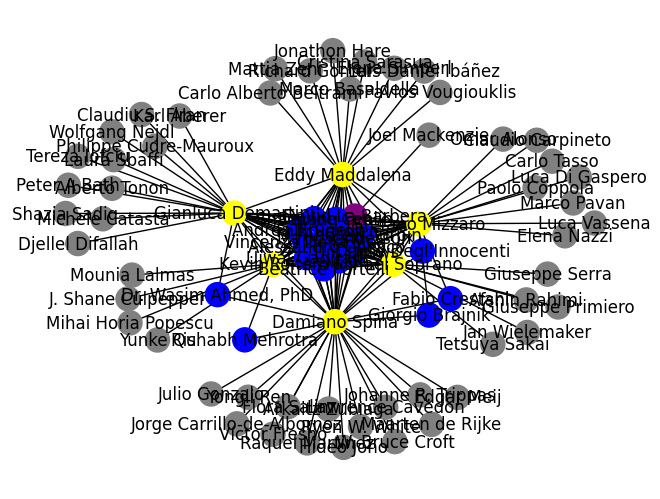

In [24]:
#coloraggio nodi, grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20,
#giallo per nodi con grado maggiore di 20

node_colors = []
for node, degree in grafo.degree():
    if degree == 1:
        node_colors.append('gray')
    elif 2 <= degree <= 10:
        node_colors.append('blue')
    elif 11 <= degree <= 20:
        node_colors.append('purple')
    else:
        node_colors.append('yellow')

plt.figure()  # Crea una nuova figura 
nx.draw(
    grafo, 
    with_labels=True, 
    pos=nx.spring_layout(grafo),
    node_color=node_colors
)

# Salva il grafico in formato PDF
plt.savefig('visualizations/graph.pdf', format='pdf') 

# Mostra il grafico
plt.show()  


#### 4

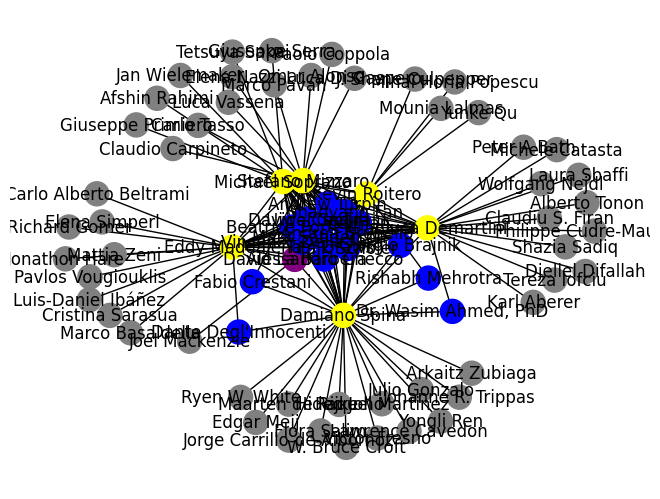

In [18]:
# Print the new edges created using Preferential Attachment
preds = nx.preferential_attachment(grafo)

# Create an empty dataframe
df_preds = pd.DataFrame(columns=['author1', 'author2', 'p'])

# Iterate over the preds tuple and add the values to the dataframe
for u, v, p in preds:
    new_row = {'author1': u, 'author2': v, 'p': p}
    df_preds = pd.concat([df_preds, pd.DataFrame([new_row])], ignore_index=True)

df_preds = df_preds.sort_values(by='p', ascending=False)
#display(df_preds)

grafo_preferential_attachment = grafo

for index, row in df_preds.head(50).iterrows():
    author1 = row['author1']
    author2 = row['author2']
    grafo_preferential_attachment.add_edge(author1, author2)
    
    
# ricalcolo i gradi per il nuovo grafo aumentato

node_colors = []
for node, degree in grafo_preferential_attachment.degree():
    if degree == 1:
        node_colors.append('gray')
    elif 2 <= degree <= 10:
        node_colors.append('blue')
    elif 11 <= degree <= 20:
        node_colors.append('purple')
    else:
        node_colors.append('yellow')
    

# Salva il grafo nel formato GML
nx.write_gml(grafo_preferential_attachment, "graphs/extended_coauthorship_graph.gml")

# Prepara il grafico per la visualizzazione
plt.figure()  # Crea una nuova figura per il grafico
nx.draw(
    grafo_preferential_attachment, 
    with_labels=True, 
    pos=nx.spring_layout(grafo_preferential_attachment),
    node_color=node_colors
)

# Salva il grafico in formato PDF
plt.savefig('visualizations/extended_graph.pdf', format='pdf')

# Visualizza il grafico
plt.show()

#### 5

In [19]:
# Calcolo delle metriche per il grafo
clustering_coeff_grafo = nx.average_clustering(grafo)
center_grafo = nx.center(grafo)
radius_grafo = nx.radius(grafo)
medium_distance_grafo = nx.average_shortest_path_length(grafo)
transitivity_grafo = nx.transitivity(grafo)
omega_grafo = nx.omega(grafo)
sigma_grafo = nx.sigma(grafo)

In [20]:
# Calcolo delle metriche per il grafo esteso
clustering_coeff_grafo_pa = nx.average_clustering(grafo_preferential_attachment)
center_grafo_pa = nx.center(grafo_preferential_attachment)
radius_grafo_pa = nx.radius(grafo_preferential_attachment)
medium_distance_grafo_pa = nx.average_shortest_path_length(grafo_preferential_attachment)
transitivity_grafo_pa = nx.transitivity(grafo_preferential_attachment)
omega_grafo_pa = nx.omega(grafo_preferential_attachment)
sigma_grafo_pa = nx.sigma(grafo_preferential_attachment)

In [21]:
info_graphs = pd.DataFrame(columns=['average clustering coefficient', 'center', 'radius', 'medium distance', 'transitivity', 'omega', 'sigma'])

# Dataframe 
info_graphs.loc[0] = {'average clustering coefficient': clustering_coeff_grafo, 
                      'center': center_grafo, 
                      'radius': radius_grafo, 
                      'medium distance': medium_distance_grafo, 
                      'transitivity': transitivity_grafo, 

                      'omega': omega_grafo, 
                      'sigma': sigma_grafo
                     }

info_graphs.loc[1] = {'average clustering coefficient': clustering_coeff_grafo_pa, 
                      'center': center_grafo_pa, 
                      'radius': radius_grafo_pa, 
                      'medium distance': medium_distance_grafo_pa, 

                      'transitivity': transitivity_grafo_pa, 
                      'omega': omega_grafo_pa, 
                      'sigma': sigma_grafo_pa
                     }

display(info_graphs)

# Percorso del file in cui salvare il DataFrame
results_file_path = 'results/graph_metrics.csv'

# Salvataggio del DataFrame in un file CSV nella cartella /results
info_graphs.to_csv(results_file_path, index=False)


,average clustering coefficient,center,radius,medium distance,transitivity,omega,sigma
0,0.250688,"[Alessandro Checco, Damiano Spina, David La Ba...",2,2.384211,0.288505,0.002543,0.998955
1,0.250688,"[Alessandro Checco, Damiano Spina, David La Ba...",2,2.384211,0.288505,0.002003,0.999191


#### 6

In [22]:
def calculate_metrics(graph):
    # Calcolo delle metriche
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    pagerank = nx.pagerank(graph)
    hubs, authorities = nx.hits(graph)

    # Creazione di un DataFrame per riassumere le metriche
    metrics_df = pd.DataFrame({
        'Degree Centrality': degree_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Closeness Centrality': closeness_centrality,
        'Pagerank': pagerank,
        'Hubs': hubs,
        'Authorities': authorities
    })

    return metrics_df

# Calcolo delle metriche per il grafo originale e quello con preferential attachment
metrics_grafo = calculate_metrics(grafo)
metrics_grafo_pa = calculate_metrics(grafo_preferential_attachment)

# Salvataggio dei DataFrame nelle cartelle /results
metrics_grafo.to_csv('results/metrics_grafo.csv', index=False)
metrics_grafo_pa.to_csv('results/metrics_grafo_pa.csv', index=False)

#### 7

In [23]:
def save_graph_html(graph, file_name):
    net = Network(height="750px", width="100%", bgcolor="#000000", font_color="white")

    # Calcola il grado di ogni nodo
    degrees = dict(graph.degree())

    # Trova il grado massimo per normalizzare le dimensioni dei nodi
    max_degree = max(degrees.values())

    # Aggiunta dei nodi con personalizzazione
    for node in graph.nodes():
        size = 10 + (degrees[node] / max_degree) * 15  # Dimensione basata sul grado
        title = f"Grado: {degrees[node]}"  # Tooltip per il nodo

        # Assegna un colore in base al grado del nodo
        if degrees[node] == 1:
            color = 'green'
        elif 2 <= degrees[node] <= 10:
            color = 'blue'
        elif 11 <= degrees[node] <= 20:
            color = 'orange'
        else:
            color = 'red'

        net.add_node(node, title=title, size=size, color=color)

    # Aggiunta degli archi
    for source, target in graph.edges():
        net.add_edge(source, target, color = 'white')

    # Impostazioni della fisica del grafo
    net.toggle_physics(True)
    net.set_options("""
    var options = {
      "physics": {
        "barnesHut": {
          "springLength": 200
        },
        "minVelocity": 0.75
      }
    }
    """)

    # Salvataggio del grafo in HTML
    net.save_graph(f'visualizations/{file_name}')

# Personalizzazione e salvataggio delle visualizzazioni per entrambi i grafi
save_graph_html(grafo, 'grafo.html')
save_graph_html(grafo_preferential_attachment, 'grafo_pa.html')